In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
def f(abscissa):
    return 2 * abscissa ** 2 + abscissa + 1

In [3]:
NUM_EXAMPLES = 1000

In [4]:
data_x = np.linspace(-2, 2, NUM_EXAMPLES)
data_x = tf.cast(data_x, tf.float32)
noise = tf.random.normal(shape=[NUM_EXAMPLES])
data_y_true = f(data_x)
data_y = data_y_true + noise

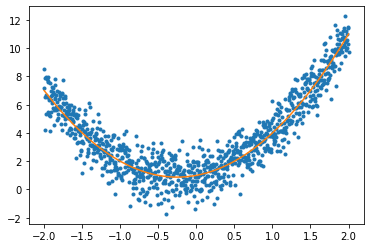

In [5]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.show()

In [43]:
initializer = tf.keras.initializers.GlorotUniform()


class CustomDense(tf.keras.layers.Layer):
    _out_features: int
    _activation: Callable[[tf.Tensor], tf.Tensor]
    _weights: tf.Variable
    _biases: tf.Variable

    def __init__(self, out_features: int, activation: Callable[[tf.Tensor], tf.Tensor] = tf.identity, **kwargs):
        super().__init__(**kwargs)
        self._out_features = out_features
        self._activation = activation

    def build(self, input_shape):
        # demonstrate different ways of weights initialization
        self._weights = self.add_weight(
                shape=(input_shape[-1], self._out_features),
                initializer=initializer,
                name='weights'
        )
        self._biases = tf.Variable(tf.zeros([self._out_features]), name='biases')

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return self._activation(tf.matmul(inputs, self._weights) + self._biases)


In [44]:
input_layer = tf.keras.Input(shape=(1,))
layer = CustomDense(32, activation=tf.nn.relu)(input_layer)
layer = CustomDense(32, activation=tf.nn.relu)(layer)
layer = CustomDense(16, activation=tf.nn.relu)(layer)
layer = CustomDense(16, activation=tf.nn.relu)(layer)
layer = CustomDense(8, activation=tf.nn.relu)(layer)
layer = CustomDense(8, activation=tf.nn.relu)(layer)
layer = CustomDense(4)(layer)
layer = CustomDense(2)(layer)
layer = CustomDense(1)(layer)

model = tf.keras.Model(inputs=input_layer, outputs=layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 custom_dense_36 (CustomDens  (None, 32)               64        
 e)                                                              
                                                                 
 custom_dense_37 (CustomDens  (None, 32)               1056      
 e)                                                              
                                                                 
 custom_dense_38 (CustomDens  (None, 16)               528       
 e)                                                              
                                                                 
 custom_dense_39 (CustomDens  (None, 16)               272       
 e)                                                        

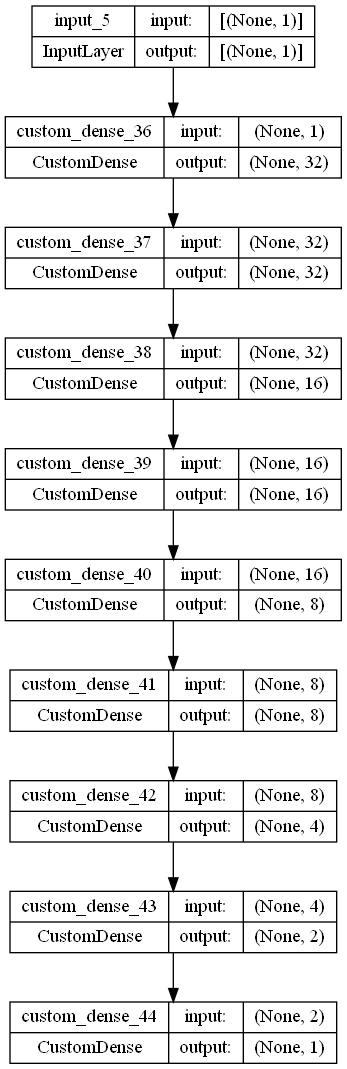

In [45]:
tf.keras.utils.plot_model(model, '../../output/my_first_model_with_shape_info.png', show_shapes=True)

In [46]:
model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.mean_squared_error,
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [47]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir='../../output/logs',
        write_graph=False,
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=0,
)
model.fit(data_x,
          data_y,
          validation_split=0.1,
          epochs=500,
          batch_size=NUM_EXAMPLES,
          callbacks=[early_stopping_callback, tensorboard_callback],
          )

Epoch 1/500
1/1 [==============================] - 1s 661ms/step - loss: 14.7704 - mean_absolute_error: 3.1935 - val_loss: 87.0367 - val_mean_absolute_error: 9.2399
Epoch 2/500
1/1 [==============================] - 0s 80ms/step - loss: 13.9983 - mean_absolute_error: 3.0855 - val_loss: 85.0199 - val_mean_absolute_error: 9.1303
Epoch 3/500
1/1 [==============================] - 0s 74ms/step - loss: 13.3832 - mean_absolute_error: 2.9967 - val_loss: 83.2988 - val_mean_absolute_error: 9.0356
Epoch 4/500
1/1 [==============================] - 0s 67ms/step - loss: 12.8292 - mean_absolute_error: 2.9143 - val_loss: 81.6106 - val_mean_absolute_error: 8.9417
Epoch 5/500
1/1 [==============================] - 0s 68ms/step - loss: 12.3007 - mean_absolute_error: 2.8347 - val_loss: 79.9332 - val_mean_absolute_error: 8.8474
Epoch 6/500
1/1 [==============================] - 0s 68ms/step - loss: 11.7915 - mean_absolute_error: 2.7565 - val_loss: 78.2544 - val_mean_absolute_error: 8.7520
Epoch 7/500
1/1

In [48]:
evaluation_results = model.evaluate(data_x, data_y, batch_size=NUM_EXAMPLES, verbose=0)
print(f'final loss: {evaluation_results[0]}')
print(f'final custom_mean_absolute_error: {evaluation_results[1]}')

final loss: 1.766882061958313
final custom_mean_absolute_error: 1.0063555240631104


In [49]:
prediction_result = model.predict(data_x, batch_size=NUM_EXAMPLES).reshape((-1,))
prediction_result

1/1 [==============================] - 0s 79ms/step


array([6.4703445, 6.466122 , 6.4619   , 6.4576774, 6.4534554, 6.4492335,
       6.4450116, 6.4407887, 6.436567 , 6.4323444, 6.4281225, 6.4239006,
       6.4196777, 6.4154553, 6.4112334, 6.407011 , 6.4027896, 6.398567 ,
       6.394345 , 6.3901224, 6.3859   , 6.3816776, 6.377456 , 6.373234 ,
       6.369012 , 6.364789 , 6.3605666, 6.3563447, 6.3521895, 6.348189 ,
       6.3441887, 6.3401885, 6.336188 , 6.332187 , 6.328187 , 6.3241863,
       6.3201857, 6.316185 , 6.3121853, 6.308184 , 6.304184 , 6.3001833,
       6.296183 , 6.2921824, 6.2881823, 6.2841816, 6.280181 , 6.2761807,
       6.27218  , 6.26818  , 6.264179 , 6.2601795, 6.256179 , 6.252178 ,
       6.2481775, 6.244177 , 6.2401767, 6.2361765, 6.232176 , 6.2281756,
       6.224175 , 6.220175 , 6.216174 , 6.212241 , 6.208374 , 6.1995173,
       6.1871967, 6.1748757, 6.1625557, 6.150234 , 6.137914 , 6.125545 ,
       6.1130457, 6.100546 , 6.088045 , 6.074916 , 6.0605855, 6.0447984,
       6.0200624, 5.995329 , 5.970595 , 5.9458594, 

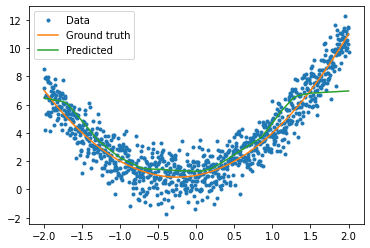

In [50]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.plot(data_x, prediction_result, label='Predicted')
plt.legend()
plt.show()